### Herramientas + Comprender y preparar los datos

In [68]:
%%time

# Herramientas

# Carga y manejo de datos
import pandas as pd
import numpy as np

# Escalado y preprocesamiento
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Clustering
from sklearn.cluster import KMeans

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Reducción de dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Almacenamiento de modelos
import pickle

# Cargar los datos
df_canciones = pd.read_csv("df_cluster_canciones.csv")
df_tracks = pd.read_csv("df_cluster_playlist.csv")

# Eliminar duplicados
df_canciones = df_canciones.drop_duplicates()

CPU times: total: 15.6 ms
Wall time: 21 ms


In [70]:
%%time

# Verificar datos
print(df_canciones.info())
print('') # Espacio en respuesta
print(df_tracks.info())
print('') # Espacio en respuesta

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   canción id            52 non-null     object 
 1   nombre                52 non-null     object 
 2   artistas              52 non-null     object 
 3   duración (segundos)   52 non-null     float64
 4   popularidad           52 non-null     int64  
 5   explícito             52 non-null     int64  
 6   fecha de lanzamiento  52 non-null     object 
 7   url de spotify        52 non-null     object 
 8   imagen                52 non-null     object 
 9   danceability          52 non-null     float64
 10  energy                52 non-null     float64
 11  valence               52 non-null     float64
 12  tempo                 52 non-null     float64
 13  acousticness          52 non-null     float64
 14  instrumentalness      52 non-null     float64
 15  speechiness           52 

### 1. Análisis exploratorio post-clustering

### Canciones (df_canciones)

In [74]:
%%time

# Seleccionar columnas numéricas
numeric_columns = df_canciones.select_dtypes(include=['number']).columns

# Verificar si hay valores no válidos en las columnas numéricas
for col in numeric_columns:
    print(f"Columna: {col}")
    print(df_canciones[col].unique())
    print("")  # Espacio para mejorar legibilidad

# Intentar convertir a numérico, reemplazando valores no válidos con NaN
for col in numeric_columns:
    df_canciones[col] = pd.to_numeric(df_canciones[col], errors='coerce')

# Revisar si hay valores NaN después de la conversión
print(df_canciones[numeric_columns].isnull().sum())

# Reemplazar valores NaN con la media de la columna
df_canciones[numeric_columns] = df_canciones[numeric_columns].fillna(df_canciones[numeric_columns].mean())

# Agrupar por 'Cluster' y calcular la media solo para las columnas numéricas
cluster_stats_canciones = df_canciones.groupby('Cluster')[numeric_columns].mean()
print(cluster_stats_canciones)

print('') # Espacio en respuesta

Columna: duración (segundos)
[251.667 169.917 210.373 170.887 225.88  166.3   157.279 211.978 175.459
 218.423 261.466 197.019 301.623 256.    195.824 180.304 186.365 208.211
 226.6   240.4   180.386 157.146 210.688 233.478 155.757 255.915 171.869
 183.956 145.473 253.834 266.773 136.627 153.928 244.684 220.734 190.427
 206.693 278.014 251.424 171.291 165.412 159.245 224.022 191.7   130.88
  86.983 204.28  192.755 181.064 228.639 142.514]

Columna: popularidad
[100  97  92  88  94  89  82  93  87  90  86  91  84  85  80  83  53]

Columna: explícito
[0 1]

Columna: danceability
[0.521 0.777 0.747 0.66  0.694 0.554 0.674 0.494 0.699 0.7   0.467 0.576
 0.574 0.769 0.924 0.472 0.675 0.448 0.672 0.612 0.558 0.53  0.561 0.726
 0.733 0.505 0.739 0.464 0.724 0.373 0.429 0.894 0.745 0.264 0.635 0.466
 0.853 0.392 0.74  0.722 0.661 0.689 0.56  0.569 0.744 0.482 0.483 0.955
 0.732 0.645 0.599]

Columna: energy
[0.592 0.783 0.507 0.756 0.651 0.808 0.907 0.413 0.776 0.582 0.247 0.884
 0.659 0.722 0

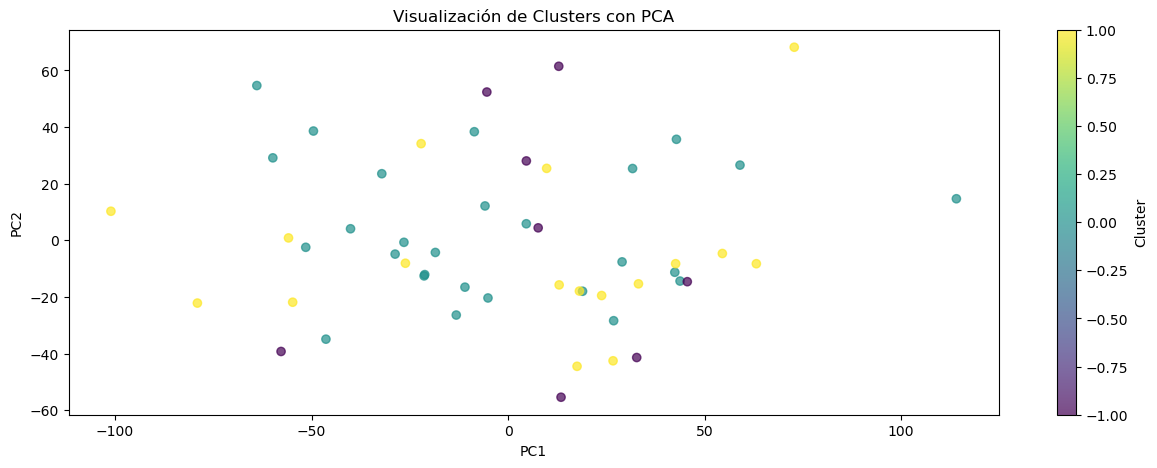

CPU times: total: 1.73 s
Wall time: 258 ms


In [76]:
%%time

# Visualización de los clusters
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(df_canciones[numeric_columns])

plt.figure(figsize = (15, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c = df_canciones['Cluster'], cmap = 'viridis', alpha = 0.7)
plt.colorbar(label = 'Cluster')
plt.title('Visualización de Clusters con PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

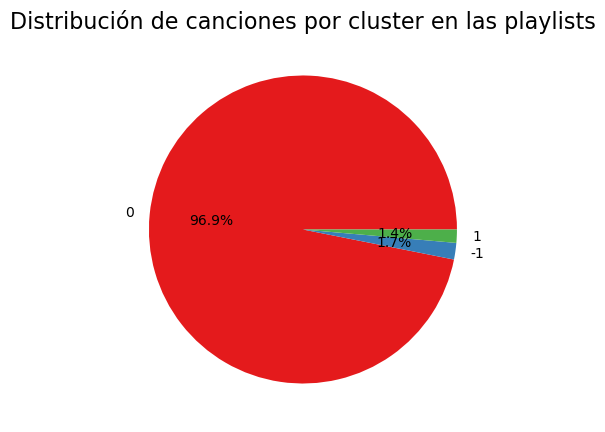

CPU times: total: 109 ms
Wall time: 103 ms


In [77]:
%%time

# Distribución de canciones por cluster en las playlists
plt.figure(figsize = (15, 5))
df_tracks['Cluster'].value_counts().plot(kind = 'pie', autopct = '%1.1f%%', colors = sns.color_palette('Set1', n_colors = 4))
plt.title('Distribución de canciones por cluster en las playlists', fontsize = 16)
plt.ylabel('')
plt.show()

In [78]:
%%time

# Validación del clustering
score = silhouette_score(df_canciones[numeric_columns], df_canciones['Cluster'])
print(f'Silhouette Score: {score}')

Silhouette Score: -0.023223221128187567
CPU times: total: 0 ns
Wall time: 4.01 ms


In [80]:
%%time

# Guardamos CSV
df_canciones.to_csv('canciones_clusterizadas.csv', index = False)

CPU times: total: 0 ns
Wall time: 2.5 ms


In [84]:
%%time

# Recomendación de canciones.
def recomendar_canciones(cancion_id, df, n=5):
    cluster_id = df.loc[cancion_id, 'Cluster']
    canciones_similares = df[df['Cluster'] == cluster_id].sample(n)
    return canciones_similares[['nombre', 'artistas']]

recomendaciones = recomendar_canciones(cancion_id = 0, df = df_canciones)
print(recomendaciones)

                     nombre               artistas
24  Moonlit Floor (Kiss Me)                   LISA
15         Beautiful Things           Benson Boone
0          Die With A Smile  Lady Gaga, Bruno Mars
19          Sweater Weather      The Neighbourhood
7               Sailor Song             Gigi Perez
CPU times: total: 0 ns
Wall time: 3.01 ms


### Otros modelados para canciones

### Modelado predictivo

In [88]:
%%time

# Selección de columnas numéricas relevantes para clustering
numeric_columns_canciones = ['duración (segundos)', 'danceability', 'energy', 'valence', 'tempo', 'acousticness', 'instrumentalness', 'speechiness']

# Definir las características y la variable objetivo
X = df_canciones[numeric_columns_canciones]
y = df_canciones['popularidad']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de regresión lineal
model_lr = LinearRegression()

# Ajustar el modelo
model_lr.fit(X_train, y_train)

# Predecir sobre los datos de prueba
y_pred = model_lr.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE) de la regresión lineal: {mse}')

Mean Squared Error (MSE) de la regresión lineal: 269.0389364372983
CPU times: total: 0 ns
Wall time: 7.02 ms


### Random Forest Regressor para popularidad

In [91]:
%%time

# Crear el modelo RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

# Ajustar el modelo
model_rf.fit(X_train, y_train)

# Predecir sobre los datos de prueba
y_pred_rf = model_rf.predict(X_test)

# Evaluar el modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error (MSE) de RandomForestRegressor: {mse_rf}')

Mean Squared Error (MSE) de RandomForestRegressor: 18.21880433838383
CPU times: total: 141 ms
Wall time: 152 ms


### Análisis de Componentes Principales (PCA)

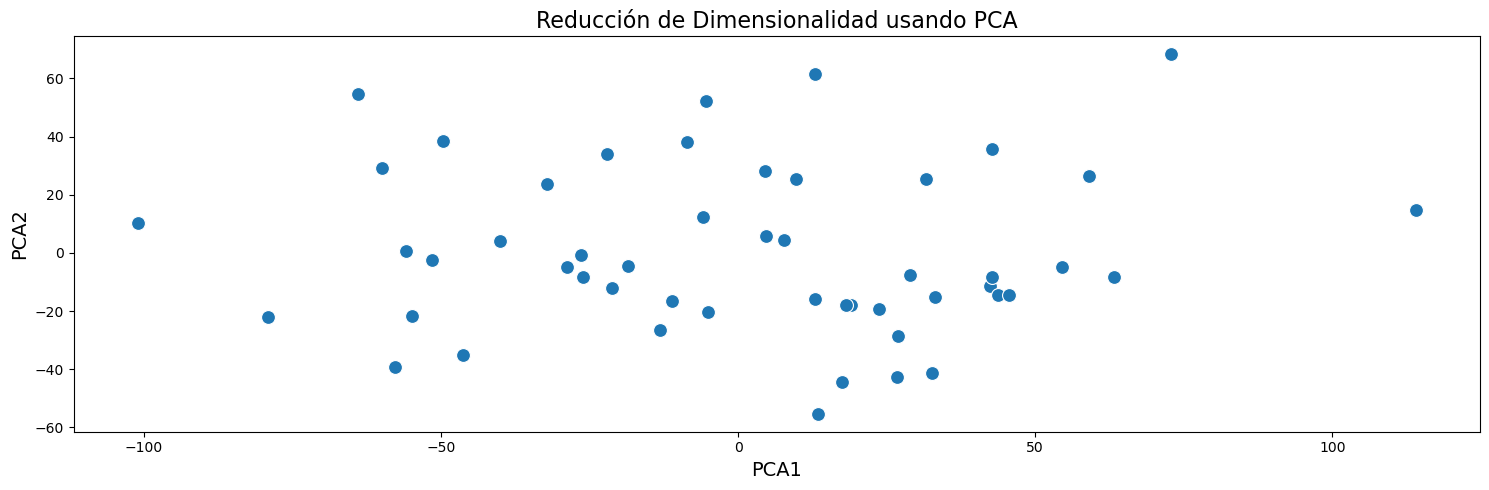

CPU times: total: 1.67 s
Wall time: 236 ms


In [94]:
%%time

# Ajustar PCA
pca_canciones = PCA(n_components = 2)  # Reducir a 2 componentes principales
df_canciones_pca = pca_canciones.fit_transform(df_canciones[numeric_columns_canciones])

# Crear un DataFrame con los componentes principales
df_pca_canciones = pd.DataFrame(df_canciones_pca, columns = ['PCA1', 'PCA2'])

# Visualizar la reducción de dimensionalidad
plt.figure(figsize = (15, 5))
sns.scatterplot(x = 'PCA1', y = 'PCA2', data = df_pca_canciones, s = 100, marker = 'o')
plt.title('Reducción de Dimensionalidad usando PCA', fontsize = 16)
plt.xlabel('PCA1', fontsize = 14)
plt.ylabel('PCA2', fontsize = 14)
plt.tight_layout()
plt.show()

In [95]:
### FIN DE CANCIONES ###

### Playlist (df_tracks)

In [99]:
%%time

# Tamaño de cada cluster en df_tracks
print("Tamaño de cada cluster:")
print(df_tracks['Cluster'].value_counts())
print('') # Espacio en respuesta

# Seleccionar columnas numéricas en df_tracks
numeric_columns_tracks = df_tracks.select_dtypes(include=['number']).columns

# Características promedio por cluster en df_tracks
print("Características promedio por cluster:")
cluster_stats_tracks = df_tracks.groupby('Cluster')[numeric_columns_tracks].mean()
print(cluster_stats_tracks)
print('') # Espacio en respuesta

# Ejemplos representativos por cluster en df_tracks
print("Ejemplos representativos por cluster:")
for cluster_id in df_tracks['Cluster'].unique():
    print(f"Cluster {cluster_id}:")
    print(df_tracks[df_tracks['Cluster'] == cluster_id].head())
    print('') # Espacio en respuesta

Tamaño de cada cluster:
Cluster
 0    1115
-1      20
 1      16
Name: count, dtype: int64

Características promedio por cluster:
         duración (segundos)  danceability    energy   valence       tempo  \
Cluster                                                                      
-1                265.527851      0.533623  0.572426  0.421831  115.173158   
 0                217.974783      0.637166  0.665969  0.543966  122.041743   
 1                185.997213      0.491297  0.184719  0.239134  114.625260   

         acousticness  instrumentalness  speechiness  explícito  clave (key)  \
Cluster                                                                        
-1           0.456632          0.245525     0.245740   0.236230     5.503933   
 0           0.247859          0.041847     0.085003   0.174356     5.313745   
 1           0.886108          0.847793     0.054972   0.000625     4.893860   

         modo (mode)  Cluster  
Cluster                        
-1          0.

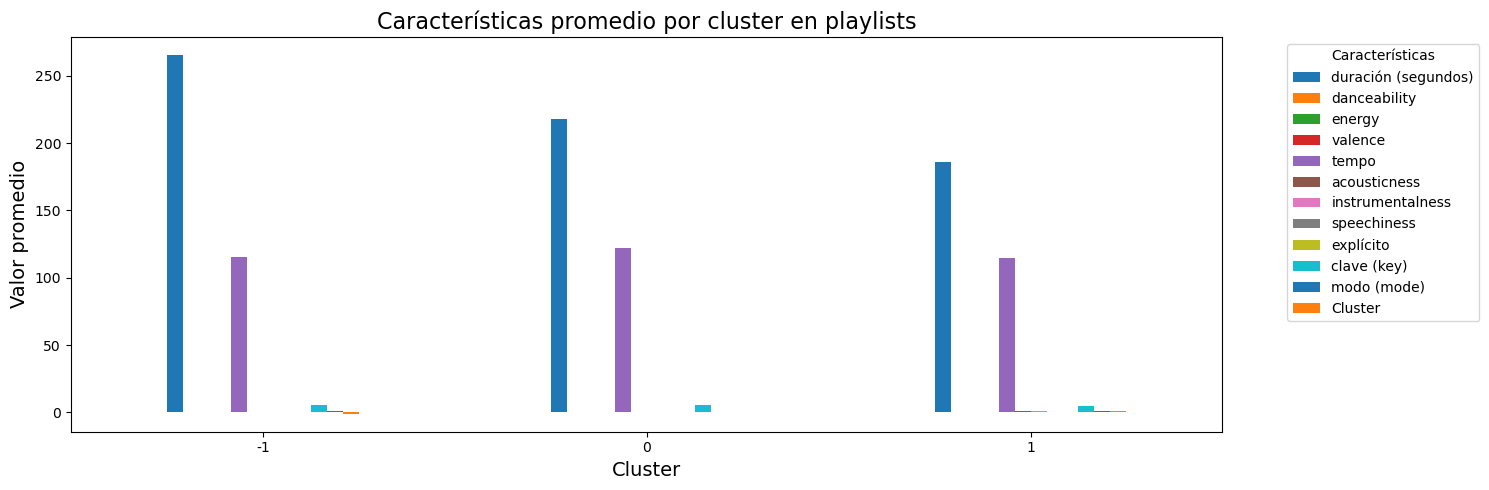

CPU times: total: 297 ms
Wall time: 315 ms


In [100]:
%%time

# Graficar las características promedio por cluster
plt.figure(figsize = (15, 5))

# Crear un gráfico de barras para cada característica por cluster
cluster_stats_tracks.plot(kind = 'bar', ax = plt.gca())

plt.title('Características promedio por cluster en playlists', fontsize = 16)
plt.xlabel('Cluster', fontsize = 14)
plt.ylabel('Valor promedio', fontsize = 14)
plt.xticks(rotation = 0)
plt.legend(title = 'Características', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.tight_layout()

plt.show()

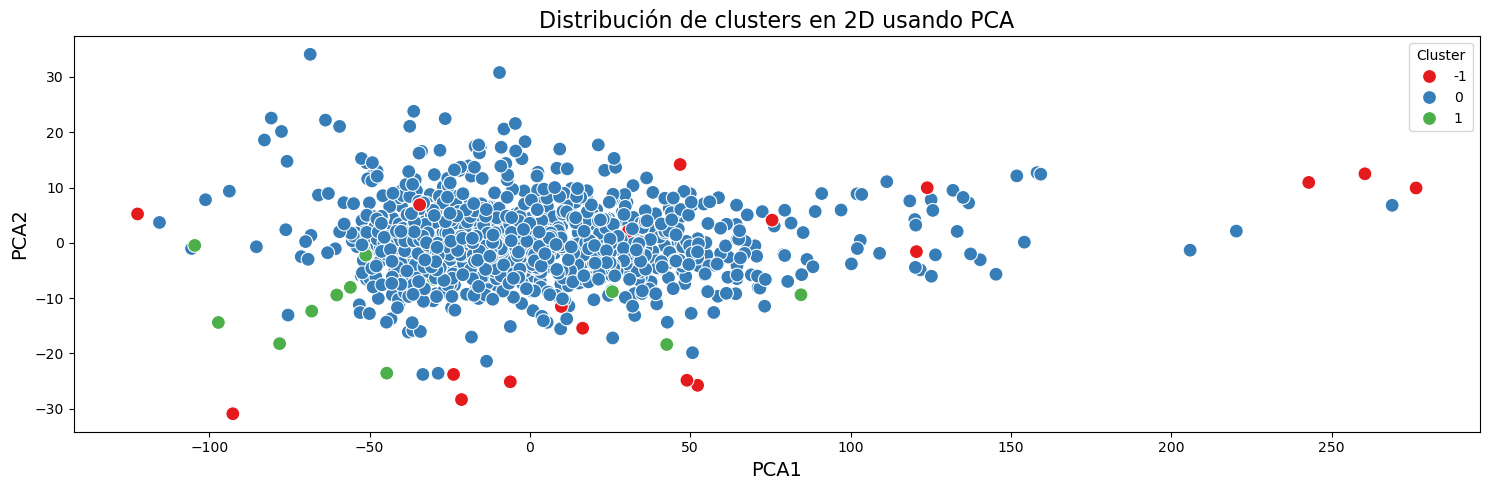

CPU times: total: 1.86 s
Wall time: 332 ms


In [102]:
%%time

# Seleccionar las características numéricas
numeric_columns_tracks = df_tracks.select_dtypes(include = ['number']).columns

# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components = 2)
pca_components = pca.fit_transform(df_tracks[numeric_columns_tracks])

# Crear un DataFrame con las componentes PCA y los clusters
df_pca = pd.DataFrame(data = pca_components, columns = ['PCA1', 'PCA2'])
df_pca['Cluster'] = df_tracks['Cluster']

# Graficar los resultados de PCA
plt.figure(figsize = (15, 5))
sns.scatterplot(x = 'PCA1', y = 'PCA2', hue = 'Cluster', data = df_pca, palette = 'Set1', s = 100, marker = 'o')
plt.title('Distribución de clusters en 2D usando PCA', fontsize = 16)
plt.xlabel('PCA1', fontsize = 14)
plt.ylabel('PCA2', fontsize = 14)
plt.legend(title = 'Cluster')
plt.tight_layout()
plt.show()

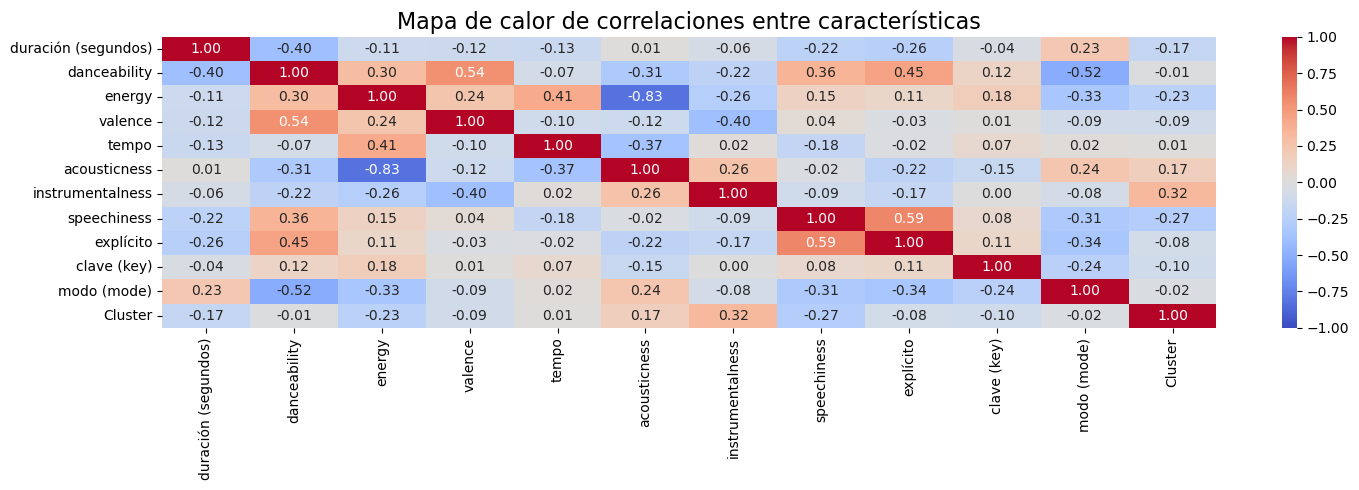

CPU times: total: 688 ms
Wall time: 625 ms


In [103]:
%%time

# Calcular la matriz de correlación
correlation_matrix = df_tracks[numeric_columns_tracks].corr()

# Graficar el mapa de calor
plt.figure(figsize = (15, 5))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', cbar = True, vmin = -1, vmax = 1)
plt.title('Mapa de calor de correlaciones entre características', fontsize = 16)
plt.tight_layout()
plt.show()

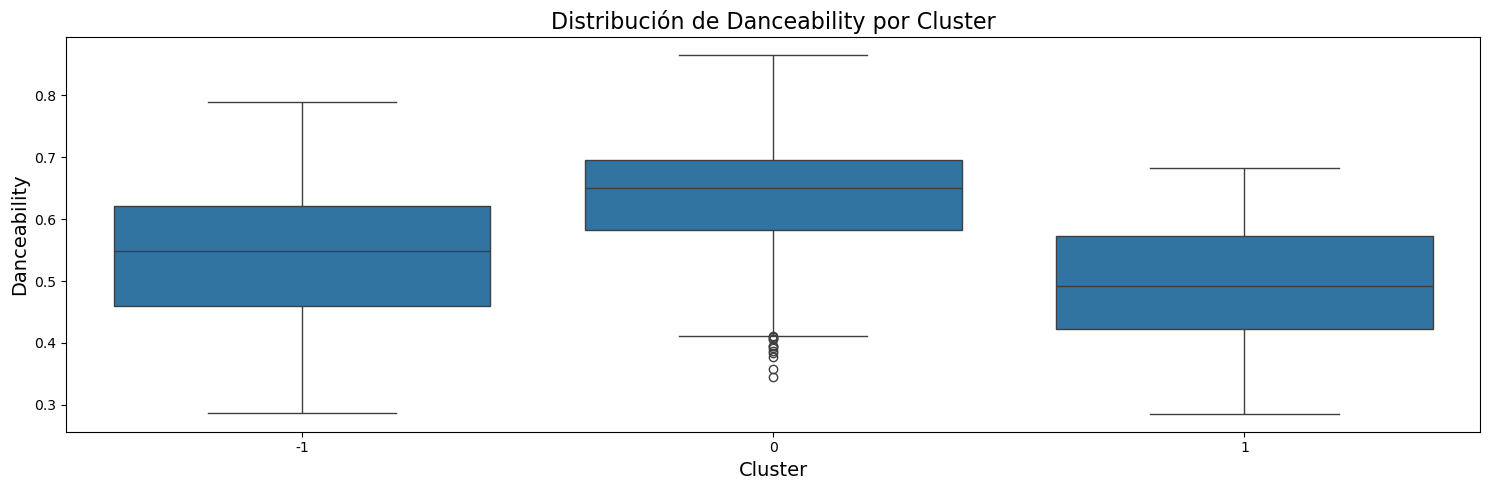

CPU times: total: 297 ms
Wall time: 219 ms


In [105]:
%%time

# Distribución de características por cluster
plt.figure(figsize=(15, 5))
sns.boxplot(x = 'Cluster', y = 'danceability', data = df_tracks)
plt.title('Distribución de Danceability por Cluster', fontsize = 16)
plt.xlabel('Cluster', fontsize = 14)
plt.ylabel('Danceability', fontsize = 14)
plt.tight_layout()
plt.show()

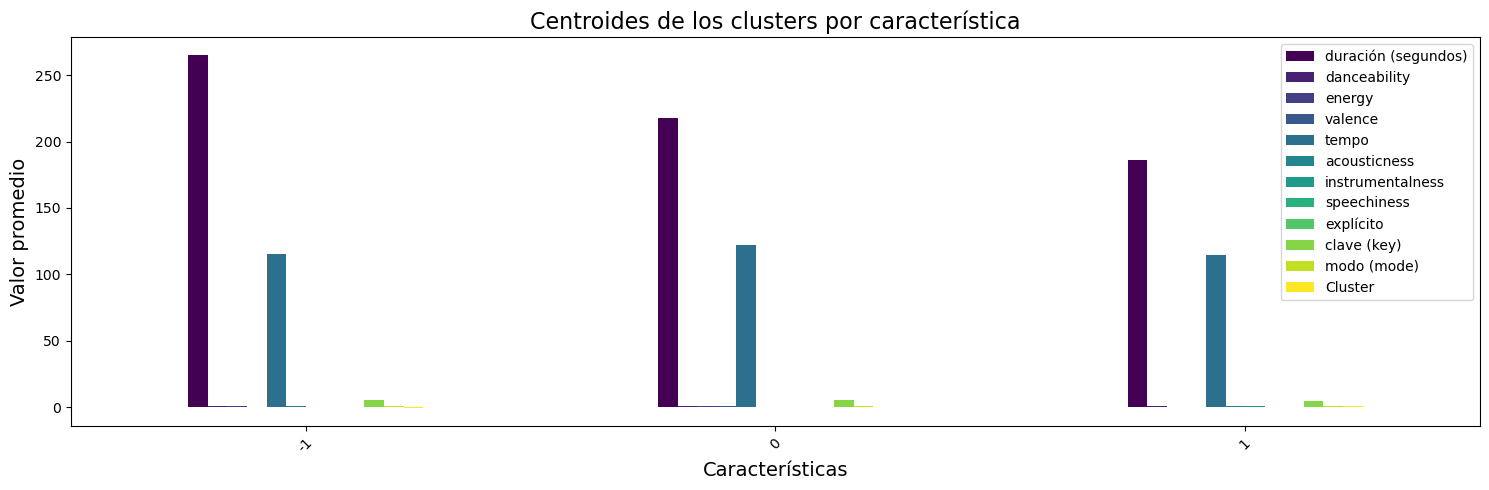

CPU times: total: 344 ms
Wall time: 333 ms


In [106]:
%%time

# Centroides de los Clusters

# Calcular los centroides de cada cluster (ya calculado previamente en cluster_stats_tracks)
centroides = cluster_stats_tracks

# Graficar los centroides de los clusters
centroides.plot(kind = 'bar', figsize = (15, 5), colormap = 'viridis')
plt.title('Centroides de los clusters por característica', fontsize = 16)
plt.xlabel('Características', fontsize = 14)
plt.ylabel('Valor promedio', fontsize = 14)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

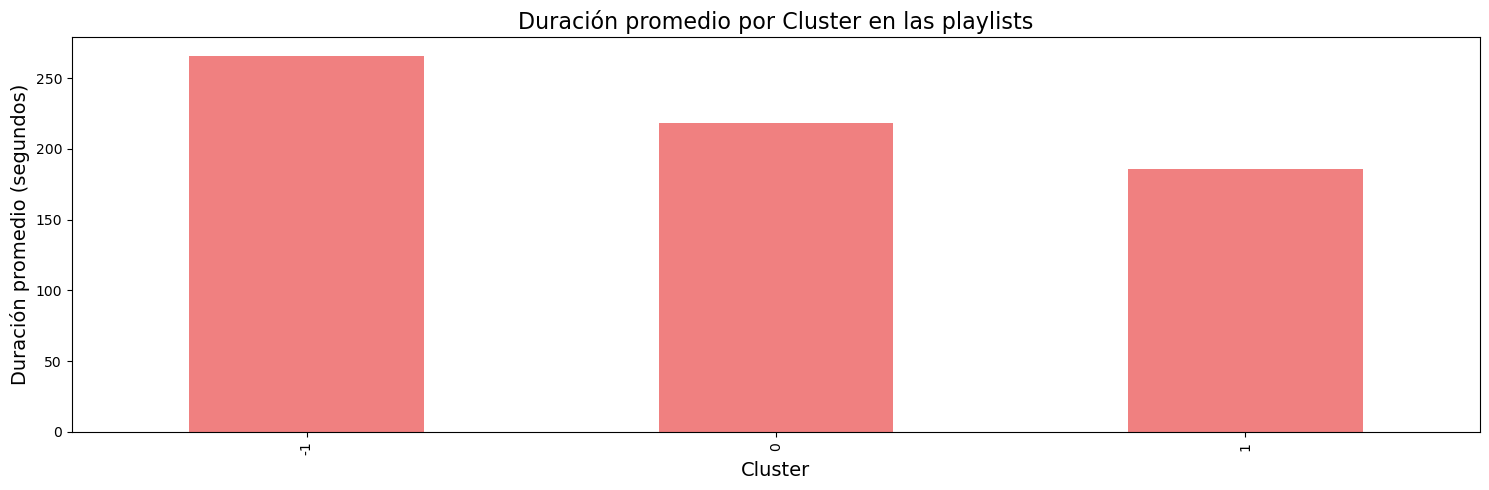

CPU times: total: 172 ms
Wall time: 165 ms


In [107]:
%%time

# Duración promedio por cluster
duracion_cluster = df_tracks.groupby('Cluster')['duración (segundos)'].mean()

# Graficar
plt.figure(figsize = (15, 5))
duracion_cluster.plot(kind = 'bar', color = 'lightcoral')
plt.title('Duración promedio por Cluster en las playlists', fontsize = 16)
plt.xlabel('Cluster', fontsize = 14)
plt.ylabel('Duración promedio (segundos)', fontsize = 14)
plt.tight_layout()
plt.show()

### Otros modelados para playlist

### Reducción de Dimensionalidad con t-SNE

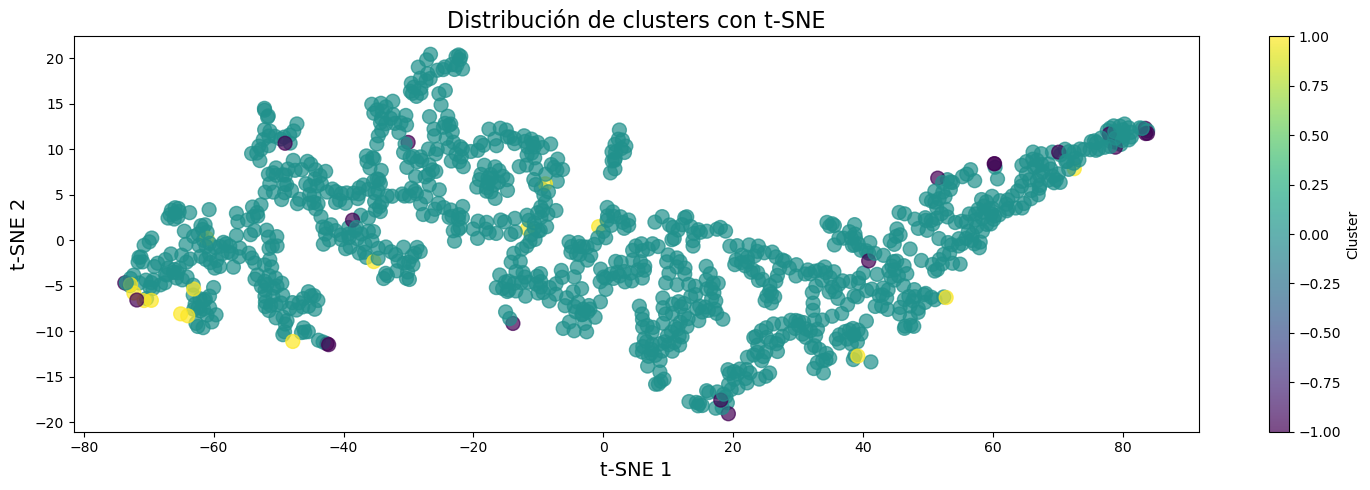

CPU times: total: 28.1 s
Wall time: 3.48 s


In [111]:
%%time

# Reducir dimensiones con t-SNE
tsne = TSNE(n_components = 2, random_state = 42)
tsne_components = tsne.fit_transform(df_tracks[numeric_columns_tracks])

# Graficar t-SNE
plt.figure(figsize = (15, 5))
plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c = df_tracks['Cluster'], cmap = 'viridis', s = 100, alpha = 0.7)
plt.title('Distribución de clusters con t-SNE', fontsize = 16)
plt.xlabel('t-SNE 1', fontsize = 14)
plt.ylabel('t-SNE 2', fontsize = 14)
plt.colorbar(label = 'Cluster')
plt.tight_layout()
plt.show()

### Modelado de Clasificación: Random Forest o XGBoost

In [114]:
%%time

# Separar variables predictoras y la variable objetivo
X = df_tracks[numeric_columns_tracks]
y = df_tracks['Cluster']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Crear el modelo
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Predecir y evaluar el modelo
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00         5
           0       1.00      1.00      1.00       335
           1       1.00      1.00      1.00         6

    accuracy                           1.00       346
   macro avg       1.00      1.00      1.00       346
weighted avg       1.00      1.00      1.00       346

CPU times: total: 219 ms
Wall time: 224 ms


In [116]:
### FIN ###